<a href="https://colab.research.google.com/github/iamatul1214/tensorflow/blob/main/Vgg_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np

In [2]:
ROOT="/content/drive/MyDrive/CNN using Pytorch"
os.chdir(ROOT)

In [3]:
!pwd

/content/drive/MyDrive/CNN using Pytorch


In [4]:
model = tf.keras.applications.VGG16(
    include_top = True, weights = "imagenet", input_tensor = None, input_shape = None, classes = 1000
)

553476096/553467096 [==============================] - 4s 0us/step


In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
main_data_dir = Path("/content/drive/MyDrive/CNN using Pytorch/hymenoptera_data/hymenoptera_data/train")
main_data_dir

PosixPath('/content/drive/MyDrive/CNN using Pytorch/hymenoptera_data/hymenoptera_data/train')

In [7]:
Batch_size = 32
Pixel = 224
Image_Size = (Pixel,Pixel)

In [8]:
datagen_kwargs = dict(rescale=1./255, validation_split=0.20)         ## For normalising the image

dataflow_kwargs = dict(target_size=Image_Size, batch_size = Batch_size)

In [9]:
## Here we are creating data_loaders but they are bit different than how we saw in pytorch

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)  

valid_generator = valid_datagen.flow_from_directory(
    main_data_dir, subset="validation", shuffle=False, **dataflow_kwargs
)

do_data_augmentation = False

if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotational_range = 40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range= 0.2,
      zoom_range=0.2,
      **datagen_kwargs 
  )

else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(
    main_data_dir, subset="training", shuffle=True, **dataflow_kwargs
)

Found 48 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [10]:
## Since we have RGB images so let's create a proper RGB image format

RGB = (Pixel,Pixel,3)

vgg = tf.keras.applications.vgg16.VGG16(
    input_shape = RGB, weights = "imagenet", include_top = False
)  
## We haveused include_top = False because we don't want the top most layer as we are doing transfer learning, we only want CNN layers and not the Fully connected layers, we will define our own fully connected layers

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
## So we downloaded just the CNN layers now we will check if they are trainable or not because our aim is to only train our fully connected layers and not the previous CNN layers

for layers in vgg.layers:
  print(f"{layers.name}: {layers.trainable}")

input_2: True
block1_conv1: True
block1_conv2: True
block1_pool: True
block2_conv1: True
block2_conv2: True
block2_pool: True
block3_conv1: True
block3_conv2: True
block3_conv3: True
block3_pool: True
block4_conv1: True
block4_conv2: True
block4_conv3: True
block4_pool: True
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True


In [13]:
## As we saw all the layers are trainable so now we will make them non trainable
for layers in vgg.layers:
  layers.trainable = False


In [14]:
## Let's check again if layers have become false
for layers in vgg.layers:
  print(f"{layers.name}: {layers.trainable}")

input_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: False
block5_pool: False


In [15]:
## Let's delete the model which we created in the starting just to see the vgg16
del model

In [16]:
## Let's check the output of the vgg model, because we will flatten that output into our fully connected layer
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [17]:
CLASSES = 2

x= tf.keras.layers.Flatten()(vgg.output)     
prediction = tf.keras.layers.Dense(CLASSES, activation="softmax")(x)

model = tf.keras.models.Model(inputs = vgg.input, outputs = prediction)

model.summary()

## The tensor must be passed to the layer when you are calling it, and not as an argument. Therefore it must be like this: therefor we use x= tf.keras.layers.Flatten()(vgg.output) 
### It is equvallent to below
# flatten_layer = Flatten()  # instantiate the layer
# x = flatten_layer(x) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),     ## Here we are using SGD but later on we can use ADAM and check as well.
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [19]:
EPOCHS = 10

history = model.fit(
    train_generator, epochs=EPOCHS, validation_data = valid_generator
)

Epoch 1/10
7/7 [==============================] - 39s 4s/step - loss: 143.7792 - accuracy: 0.4796 - val_loss: 47.0551 - val_accuracy: 0.5208
Epoch 2/10
7/7 [==============================] - 3s 418ms/step - loss: 47.7196 - accuracy: 0.6327 - val_loss: 11.5418 - val_accuracy: 0.8125
Epoch 3/10
7/7 [==============================] - 3s 415ms/step - loss: 24.6524 - accuracy: 0.7959 - val_loss: 134.3289 - val_accuracy: 0.5417
Epoch 4/10
7/7 [==============================] - 3s 423ms/step - loss: 28.2475 - accuracy: 0.8112 - val_loss: 16.6452 - val_accuracy: 0.8333
Epoch 5/10
7/7 [==============================] - 3s 448ms/step - loss: 2.7821 - accuracy: 0.9490 - val_loss: 20.6303 - val_accuracy: 0.8125
Epoch 6/10
7/7 [==============================] - 3s 413ms/step - loss: 1.1826 - accuracy: 0.9592 - val_loss: 20.4803 - val_accuracy: 0.8125
Epoch 7/10
7/7 [==============================] - 3s 423ms/step - loss: 7.3322 - accuracy: 0.9286 - val_loss: 27.0122 - val_accuracy: 0.7917
Epoch 8/1

In [20]:
## We can save the model as well, but I;m not saving as I don't have enough memory

In [21]:
train_generator.class_indices   ## Let's reverse it

{'ants': 0, 'bees': 1}

In [22]:
label_map = {value:key for key, value in train_generator.class_indices.items()}
label_map

{0: 'ants', 1: 'bees'}

In [23]:
img, label = train_generator[1]
img[1].shape    ## this is the shape we decided for our input images

(224, 224, 3)

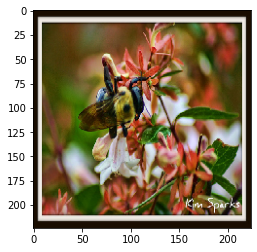

In [24]:
plt.imshow(img[1])

In [26]:
### Now let's see what the real size of image is and how it looks

test_img = plt.imread("/content/drive/MyDrive/CNN using Pytorch/hymenoptera_data/hymenoptera_data/val/ants/10308379_1b6c72e180.jpg")

In [27]:
test_img.shape    ## the shape of real image 

(375, 500, 3)

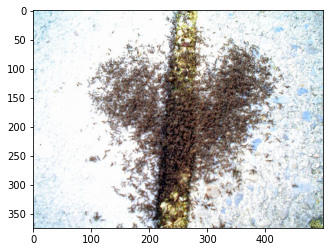

In [28]:
## Let's plot the real image
plt.imshow(test_img)

In [30]:
## Now let's try to predict using the test_img image with our model
try:
  model.predict(test_img)

except Exception as e:
  print(" We got the error because of the size of the testing image not matching with the trained size",e)

 We got the error because of the size of the testing image not matching with the trained size in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 264, in assert_input_co

In [32]:
## Let's resize the testing_image
resized_test_img = tf.image.resize(test_img,(224,224))
resized_test_img.shape

TensorShape([224, 224, 3])

In [34]:
## Now let's try to predict using the test_img image with our model
try:
  model.predict(resized_test_img)

except Exception as e:
  print(" we haven't expanded the dimensions of the testing image",e)

 we haven't expanded the dimensions of the testing image in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(

In [35]:
## Let's expand the dimensions
test_img = tf.expand_dims(resized_test_img, axis=0)
test_img.shape

TensorShape([1, 224, 224, 3])

In [36]:
pred = model.predict(test_img)
pred

array([[1., 0.]], dtype=float32)

In [38]:
## Now we will argmax
argmax = tf.argmax(pred[0]).numpy()
argmax

0

In [39]:
label_map[argmax]   ## It predicted it to be Ants which is correct

'ants'

In [50]:
test_img_squz = tf.squeeze(test_img)  ## squeezing the image to plot
test_img_squz.shape

TensorShape([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


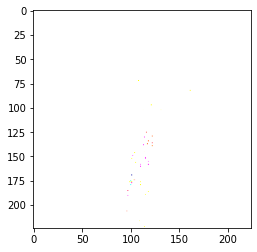

In [52]:
plt.imshow(test_img_squz)